In [157]:
num_workers = 4
seed = 42
target_name = 'p'
seed_list = [42, 7, 62, 85,  3, 19, 64, 16, 93, 20]

In [158]:
import sklearn, torch
sklearn.__version__, torch.__version__

('0.24.1', '1.8.1+cu102')

In [159]:
temp_sel_idx = 0
n_cv = 5

In [160]:
import numpy as np
sel_cv_idx = 0
jump_val = n_cv
outer_cv_part = np.arange(sel_cv_idx * jump_val, sel_cv_idx * jump_val + jump_val)
print("Total Fold: {}".format(outer_cv_part))

# select_fold = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19] #has to be list format
# print("Selected Fold: {}".format(select_fold))

Total Fold: [0 1 2 3 4]


In [161]:
import gc
import itertools
import math
import os
import pickle
import random
import time
from datetime import datetime as dt
from decimal import Decimal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pytz import timezone
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer,RobustScaler,PowerTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso,LogisticRegression
from sklearn.cross_decomposition import PLSRegression

from PIL import Image
import imageio

In [162]:
import warnings
warnings.filterwarnings('ignore')

In [163]:
def seed_everything(seed=seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

In [164]:
nowtime = dt.now(timezone("Asia/Seoul")); year = str(nowtime.year)[2:]
month = '0{}'.format(nowtime.month) if nowtime.month < 10 else str(nowtime.month)
day = '0{}'.format(nowtime.day) if nowtime.day < 10 else str(nowtime.day)
hour = '0{}'.format(nowtime.hour) if nowtime.hour < 10 else str(nowtime.hour)
minute = '0{}'.format(nowtime.minute) if nowtime.minute < 10 else str(nowtime.minute)
sec = '0{}'.format(nowtime.second) if nowtime.second < 10 else str(nowtime.second)
msec = str(nowtime.microsecond)[:2]

In [165]:
# #Using whole RSFC
data_path = "/users/hjw/data/ABCD/npz_files/rsfc_p_site_scanner_si_ge.npz"
data = np.load(data_path, allow_pickle=True)
X = data["X"]

targets_all = np.load("/data4/SNU/data/ABCD_CFA_5factor.npz",allow_pickle=True) 
target_fs = targets_all[target_name]
y = target_fs
print(X.shape, y.shape)

# X = X[np.where(y>y.min())[0]]
# y = y[np.where(y>y.min())[0]]

print(X.shape, y.shape)

(6905, 61776) (6905,)
(6905, 61776) (6905,)


In [121]:
# roi = 'DMN'
# data = np.load(f"/users/hjd/IG_my_study/ABCD/data/processed_data/rsfMRI_npz_files/ABCD_RSFC_{roi}.npz", allow_pickle=True)
# X_roi = data["data"]
# sbj = data['subjects']

# df = pd.DataFrame(data = X_roi, index=sbj)

# sgnn_sbj = np.load("/users/hjw/data/ABCD/npz_files/sbj_keys_ph.npz",allow_pickle=True)['X']

# df_fin = df.loc[['NDAR_'+i for i in sgnn_sbj]]
# df_fin.shape

# cfa_p = np.load("/users/hjw/data/ABCD/npz_files/ABCD_CFA_p.npz")["p"]
# y_temp = cfa_p.astype(np.float_).copy().reshape(-1, 1)
# y = y_temp[np.where(y_temp>y_temp.min())[0]]

# X = np.array(df_fin)[np.where(y_temp>y_temp.min())[0]]

# print(X.shape, y.shape)

In [167]:
seed_everything(seed)

from sklearn.model_selection import KFold, ShuffleSplit

outer_n_splits = n_cv

outer_train_folds_idx = []
outer_val_folds_idx = []
outer_test_folds_idx = []

outer_skf = ShuffleSplit(
    n_splits=outer_n_splits, test_size=0.20, random_state=seed)



for n_outer, (outer_train_idx, outer_test_idx) in enumerate(outer_skf.split(X, y)):
    outer_train_folds_idx.append(outer_train_idx)
    outer_test_folds_idx.append(outer_test_idx)
#     outer_val_idx = np.random.choice(outer_test1_idx,size=len(outer_test1_idx)//2,replace=False)
#     outer_test_idx = np.array([i for i in outer_test1_idx if i not in outer_val_idx])
#     outer_val_folds_idx.append(outer_val_idx)
#     outer_test_folds_idx.append(outer_test_idx)

len(outer_train_folds_idx),len(outer_train_folds_idx[0]), len(outer_val_folds_idx), len(outer_test_folds_idx[0])

(5, 5524, 0, 1381)

In [168]:
def calc_pearsonr(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    xx = (x-x_mean).flatten()
    yy = (y-y_mean).flatten()
    num = xx.dot(yy)
    den = np.linalg.norm(xx, 2) * np.linalg.norm(yy, 2)
    corr = num / den
    return corr.item()

In [169]:
krr_cc_total = []
krr_mae_total = []
krr_p_total = []

lr_ridge_cc_total = []
lr_ridge_mae_total = []
lr_ridge_p_total = []

svr_cc_total = []
svr_mae_total = []
svr_p_total = []

pls_cc_total = []
pls_mae_total = []
pls_p_total = []

for n_outer_cv in outer_cv_part:
    print(n_outer_cv+1, end =' ')
    krr = KernelRidge(kernel='rbf')
#     lr_ridge = Ridge(alpha=1.0,random_state=seed)
#     svr = SVR(C=1.0)
#     pls = PLSRegression(n_components=1)
    
    outer_train_idx = outer_train_folds_idx[n_outer_cv]
    outer_test_idx = outer_test_folds_idx[n_outer_cv]

    X_train, y_train = X[outer_train_idx], y[outer_train_idx]
    X_test, y_test = X[outer_test_idx], y[outer_test_idx]

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

    X_train = stats.zscore(X_train, axis=1)
    X_test = stats.zscore(X_test, axis=1)
    
    krr.fit(X_train, y_train)
    krr_pred = krr.predict(X_test)
    cc_fold,p_fold = stats.pearsonr(krr_pred.reshape(-1,),y_test.reshape(-1,))
    mae_fold = mean_absolute_error(krr_pred.reshape(-1,),y_test.reshape(-1,))
    krr_cc_total.append(cc_fold)
    krr_mae_total.append(mae_fold)
    krr_p_total.append(p_fold)
    
#     lr_ridge.fit(X_train, y_train)
#     lr_ridge_pred = lr_ridge.predict(X_test)
#     cc_fold,p_fold = stats.pearsonr(lr_ridge_pred.reshape(-1,),y_test.reshape(-1,))
#     mae_fold = mean_absolute_error(lr_ridge_pred.reshape(-1,),y_test.reshape(-1,))
#     lr_ridge_cc_total.append(cc_fold)
#     lr_ridge_mae_total.append(mae_fold)
#     lr_ridge_p_total.append(p_fold)
    
#     svr.fit(X_train, y_train)
#     svr_pred = svr.predict(X_test)
#     cc_fold,p_fold = stats.pearsonr(svr_pred.reshape(-1,),y_test.reshape(-1,))
#     mae_fold = mean_absolute_error(svr_pred.reshape(-1,),y_test.reshape(-1,))
#     svr_cc_total.append(cc_fold)
#     svr_mae_total.append(mae_fold)
#     svr_p_total.append(p_fold)
    
#     pls.fit(X_train, y_train)
#     pls_pred = pls.predict(X_test)
#     cc_fold,p_fold = stats.pearsonr(pls_pred.reshape(-1,),y_test.reshape(-1,))
#     mae_fold = mean_absolute_error(pls_pred.reshape(-1,),y_test.reshape(-1,))
#     pls_cc_total.append(cc_fold)
#     pls_mae_total.append(mae_fold)
#     pls_p_total.append(p_fold)
    

1 2 3 4 5 

In [170]:
krr_cc_total, krr_p_total, krr_mae_total

([0.1767511601933946,
  0.14882930304219935,
  0.11470402124290764,
  0.15599505611949652,
  0.1518052981035728],
 [3.7258692211674016e-11,
  2.7487307313486333e-08,
  1.929827845223582e-05,
  5.625760611639535e-09,
  1.43519074133784e-08],
 [0.442866220341337,
  0.4402861786686531,
  0.460465787120781,
  0.44433437027994316,
  0.44135912914464953])

In [171]:
np.mean(krr_cc_total), np.mean(krr_mae_total)

(0.1496169677403142, 0.4458623371110727)

## Grid search

In [14]:
param_cand = {'alpha':[0.01,0.1,1,10],
             'kernel':['poly','rbf'],
              'gamma':[0.001,0.01,0.1],
              'degree':[3,4,5]
             }
param_grid_list = list(ParameterGrid(param_cand))

In [15]:
result_df = pd.DataFrame(index = np.arange(len(param_grid_list)),
                         columns=list(param_cand.keys())+['corr'])

In [16]:
for idx,param in enumerate(param_grid_list):
    print(f"Start {idx+1}/{len(param_grid_list)}: {param}",end=' ')
    result_df.loc[idx,'alpha'] = param['alpha']
    result_df.loc[idx,'kernel'] = param['kernel']
    result_df.loc[idx,'gamma'] = param['gamma']
    result_df.loc[idx,'degree'] = param['degree']
    
    cc_total = []
    for n_outer_cv in outer_cv_part:
        print(n_outer_cv+1, end =' ')
        model = KernelRidge(**param)

        outer_train_idx = outer_train_folds_idx[n_outer_cv]
        outer_test_idx = outer_test_folds_idx[n_outer_cv]

        X_train, y_train = X[outer_train_idx], y[outer_train_idx]
        X_test, y_test = X[outer_test_idx], y[outer_test_idx]

        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)

        X_train = stats.zscore(X_train, axis=1)
        X_test = stats.zscore(X_test, axis=1)

        model.fit(X_train, y_train)
        model_pred = model.predict(X_test)

        cc_fold = calc_pearsonr(model_pred.reshape(-1,),y_test.reshape(-1,))
        cc_total.append(cc_fold)
    result_df.loc[idx,'corr'] = np.mean(cc_total)
    print("",end='\n')
#     break

Start 1/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'} 1 2 3 4 5 
Start 2/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf'} 1 2 3 4 5 
Start 3/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'} 1 2 3 4 5 
Start 4/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'} 1 2 3 4 5 
Start 5/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'} 1 2 3 4 5 
Start 6/72: {'alpha': 0.01, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'} 1 2 3 4 5 
Start 7/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'} 1 2 3 4 5 
Start 8/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.001, 'kernel': 'rbf'} 1 2 3 4 5 
Start 9/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'} 1 2 3 4 5 
Start 10/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.01, 'kernel': 'rbf'} 1 2 3 4 5 
Start 11/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'} 1 2 3 4 5 
Start 12/72: {'alpha': 0.01, 'degree': 4, 'gamma': 0.1, 'kernel': '

## Scale

In [13]:
# sc_list = [StandardScaler(),MinMaxScaler(),
#            QuantileTransformer(output_distribution='uniform',random_state = seed),
#            QuantileTransformer(output_distribution='normal',random_state = seed),
#            RobustScaler(),PowerTransformer()]

StandardScaler()
Fold1


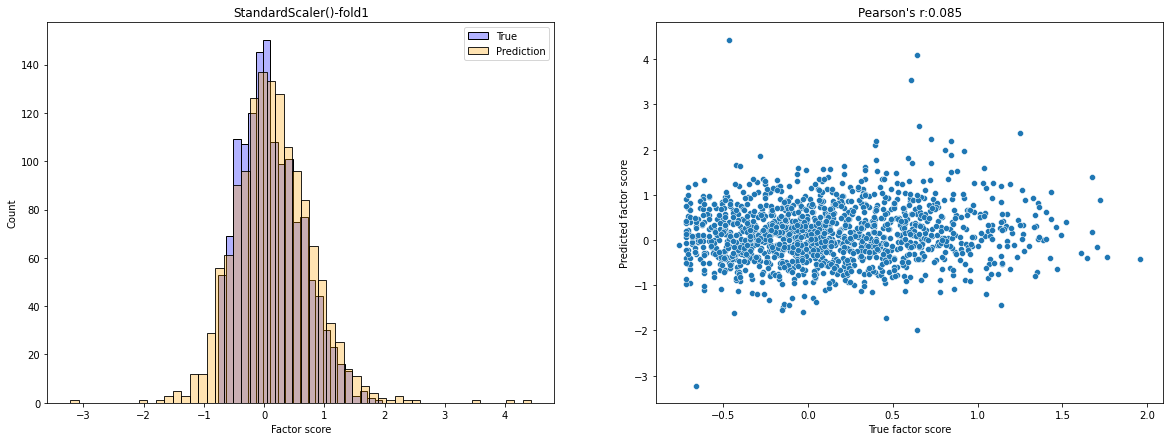

Fold2


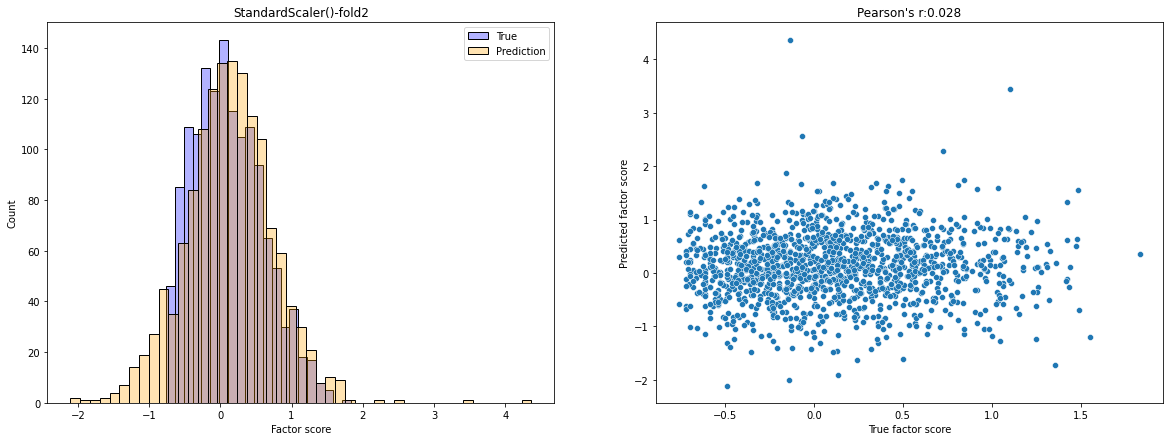

Fold3


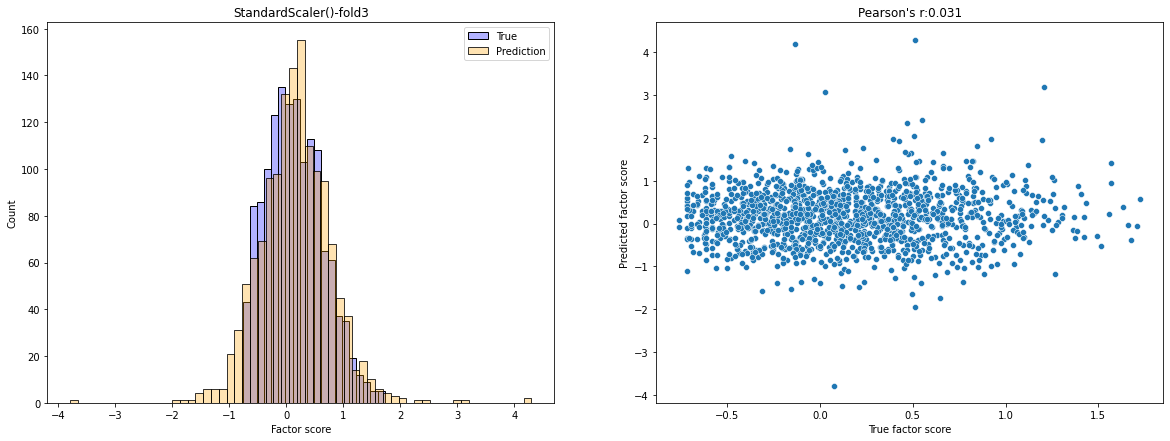

Fold4


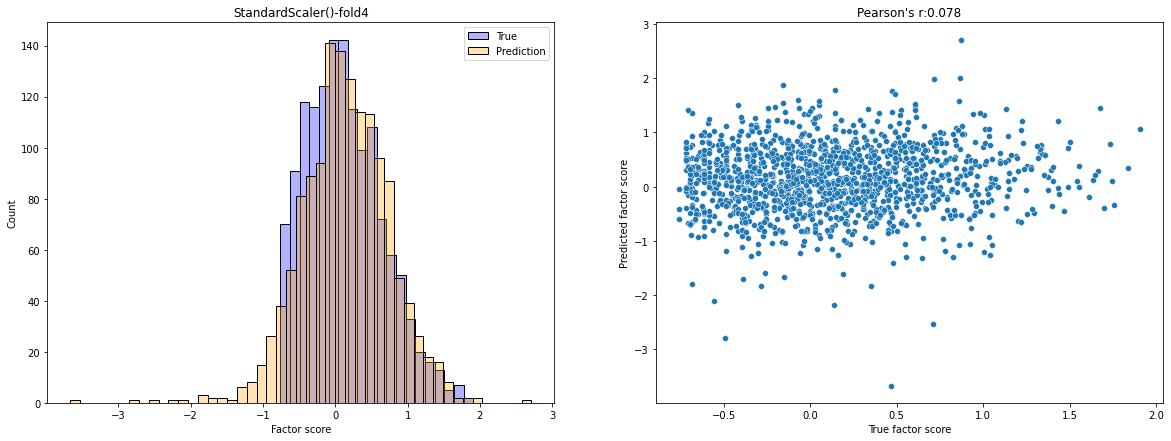

Fold5


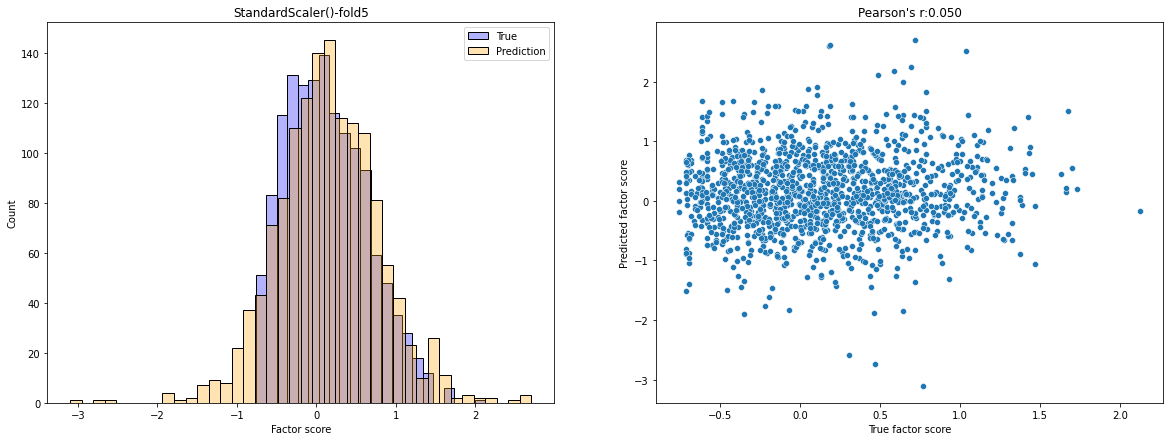

MinMaxScaler()
Fold1


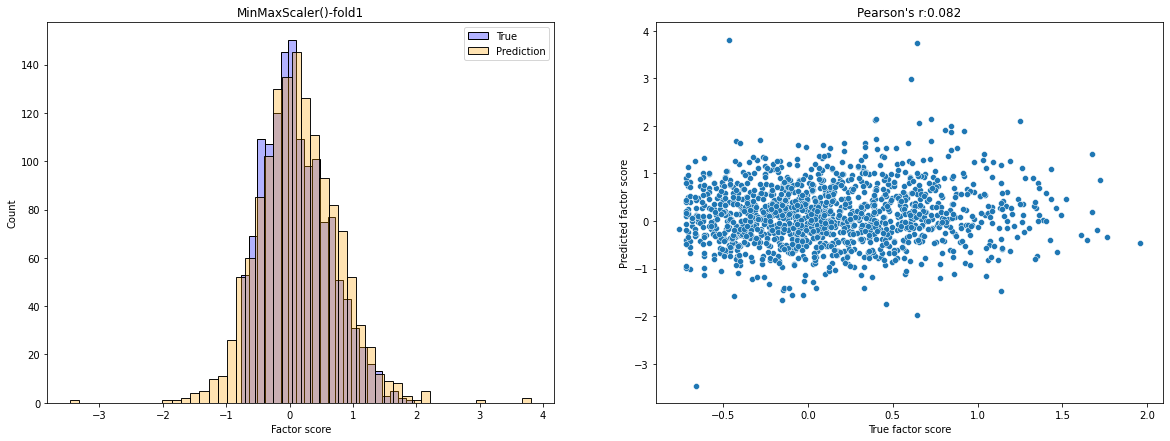

Fold2


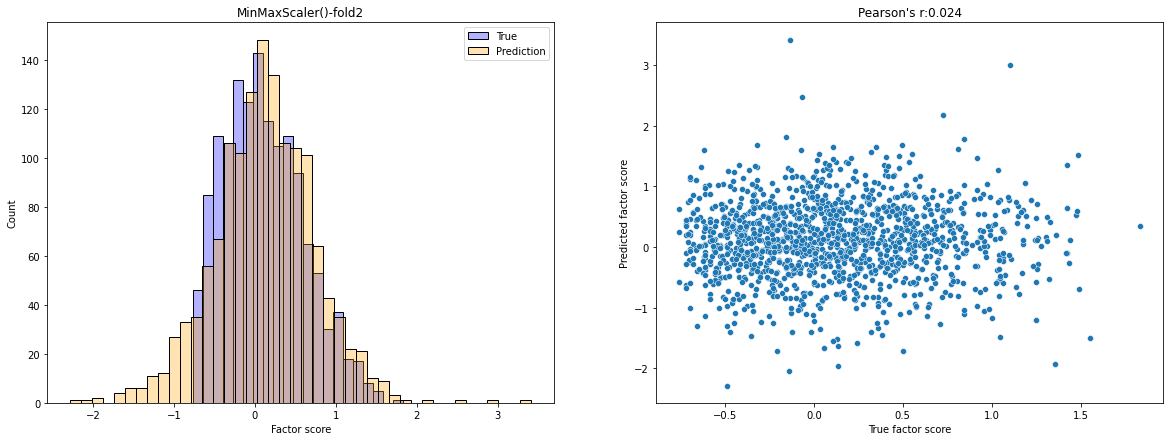

Fold3


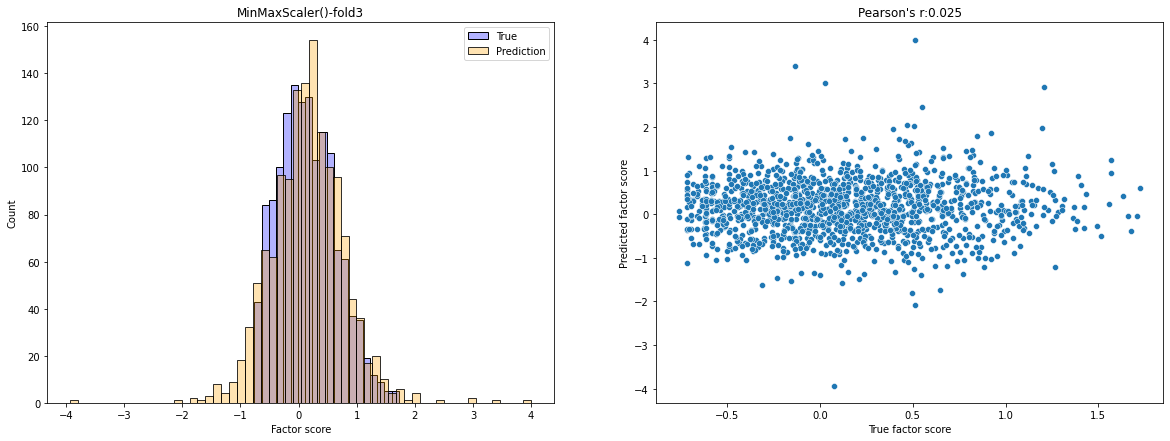

Fold4


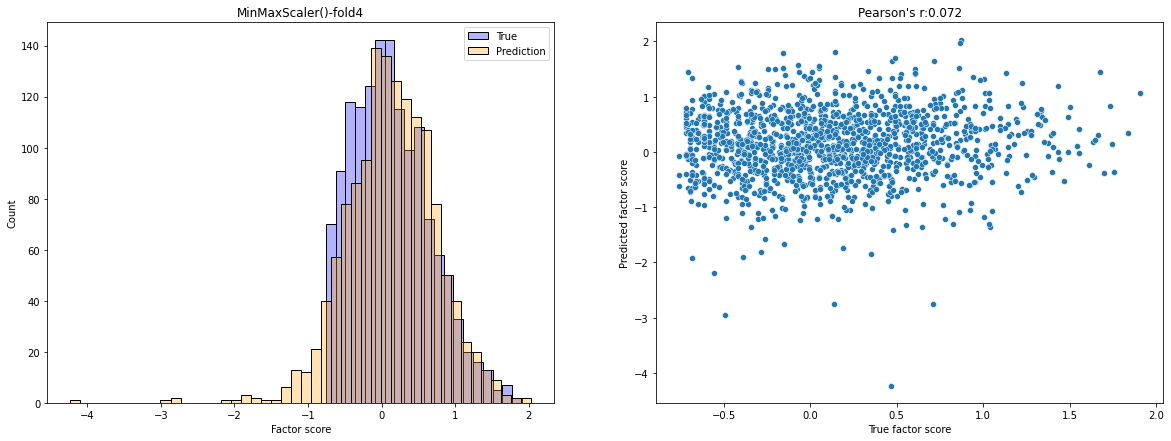

Fold5


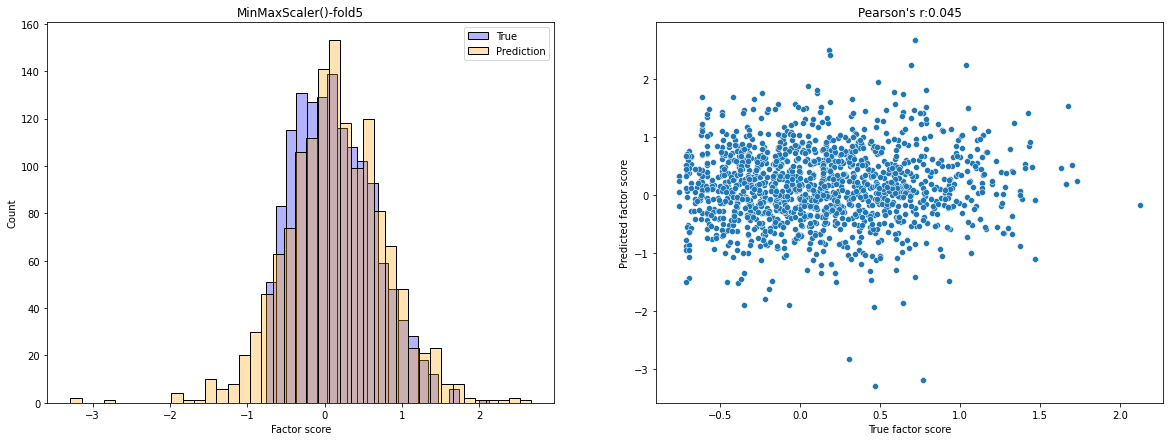

QuantileTransformer(random_state=42)
Fold1


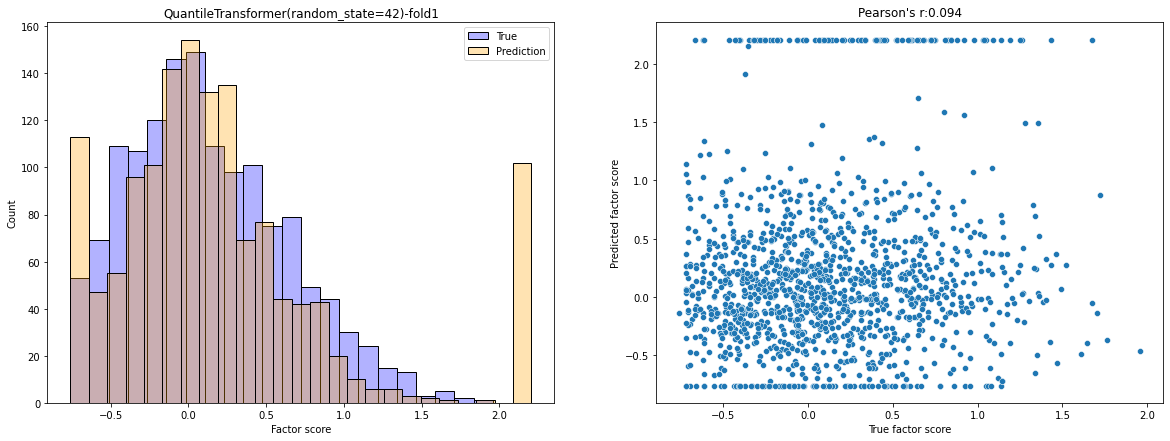

Fold2


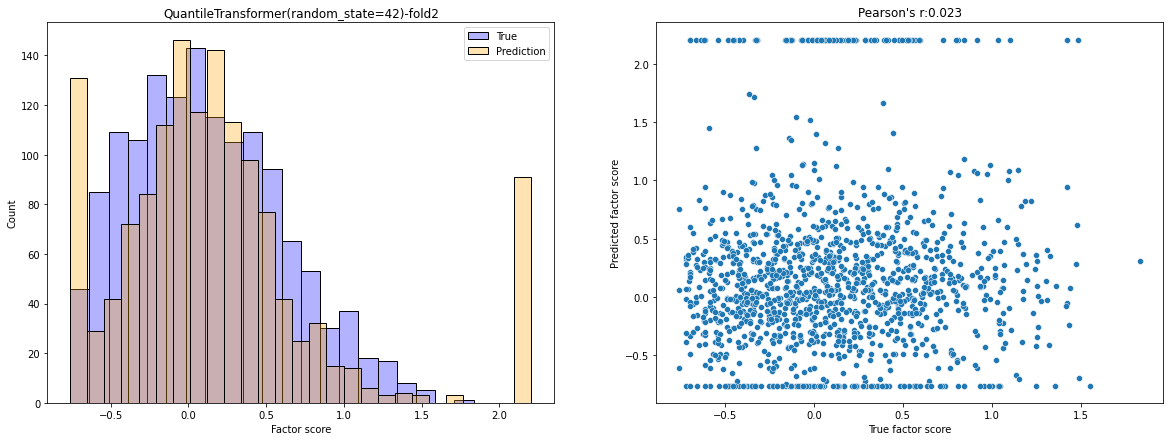

Fold3


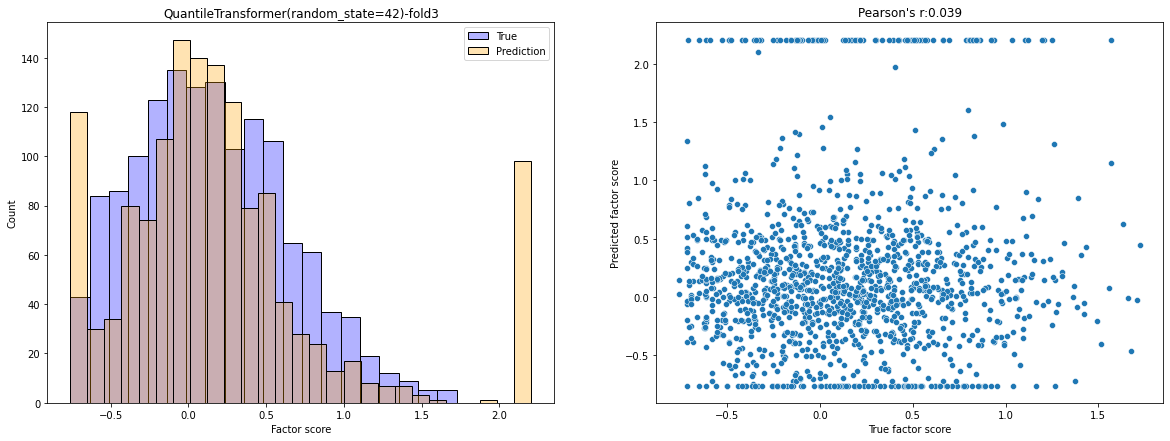

Fold4


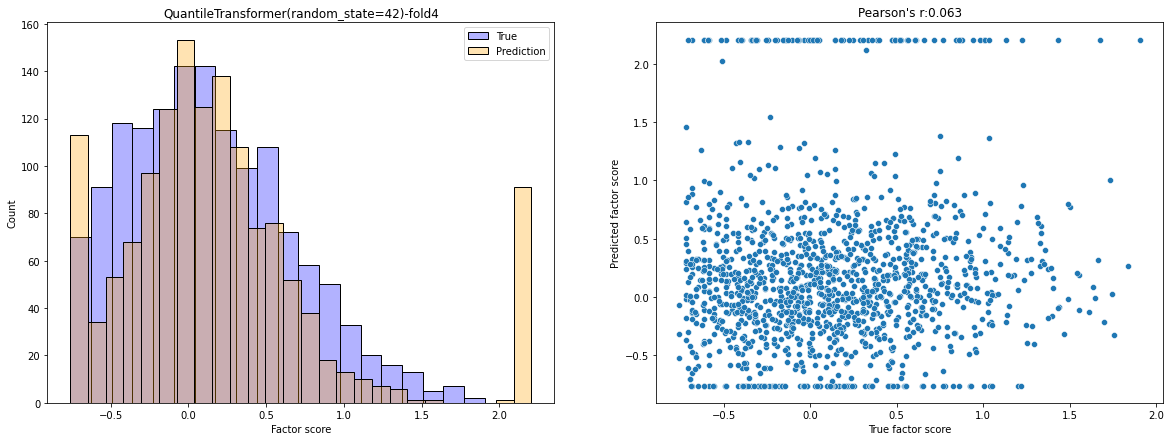

Fold5


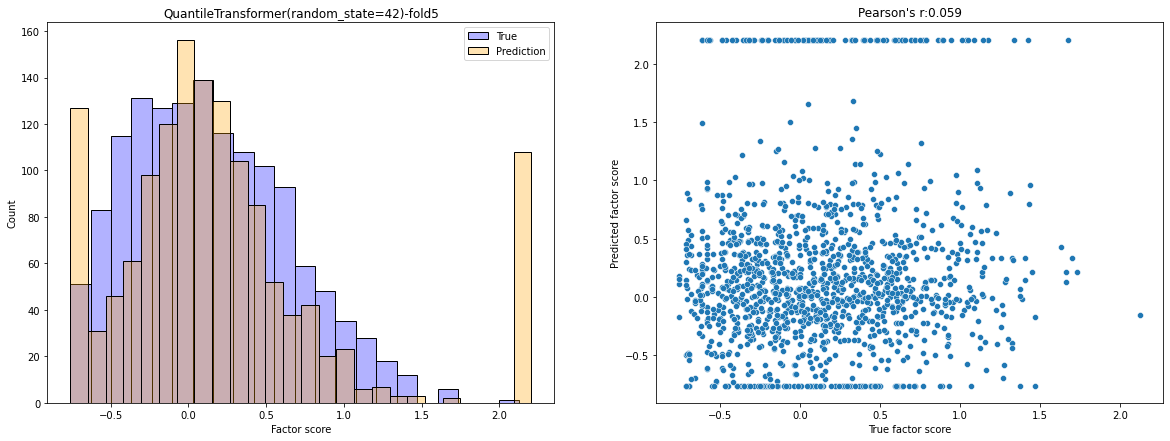

QuantileTransformer(output_distribution='normal', random_state=42)
Fold1


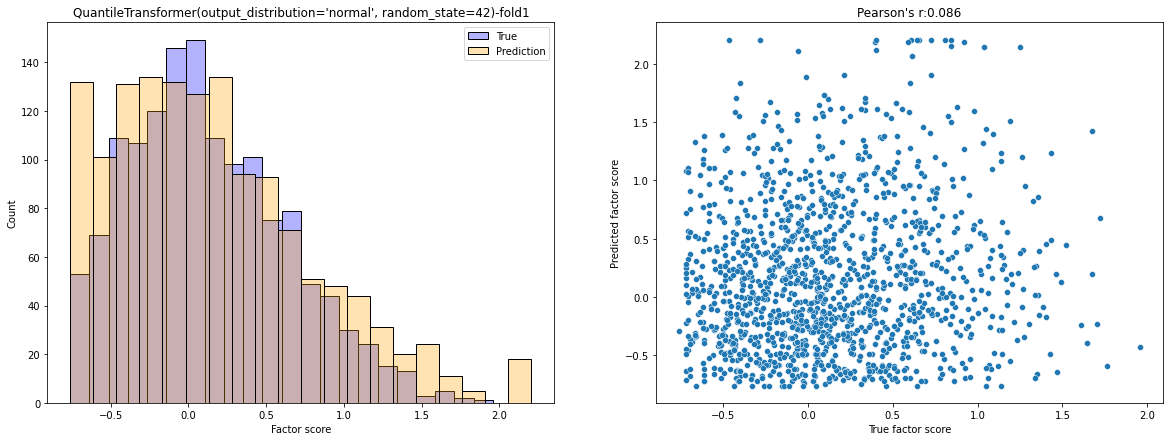

Fold2


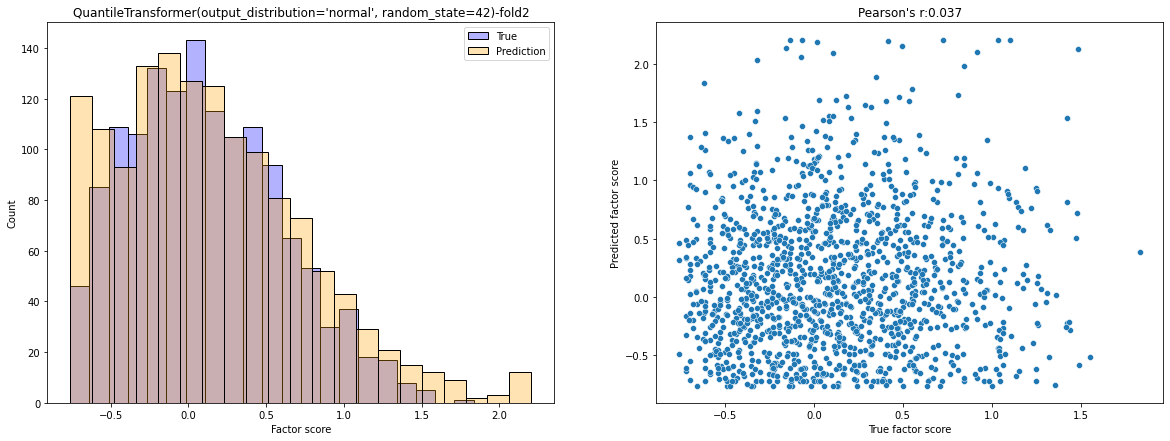

Fold3


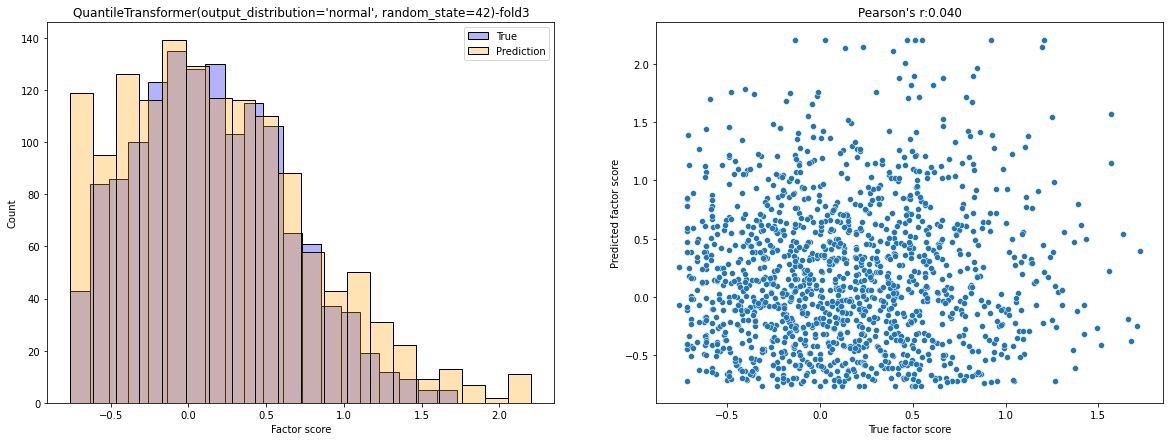

Fold4


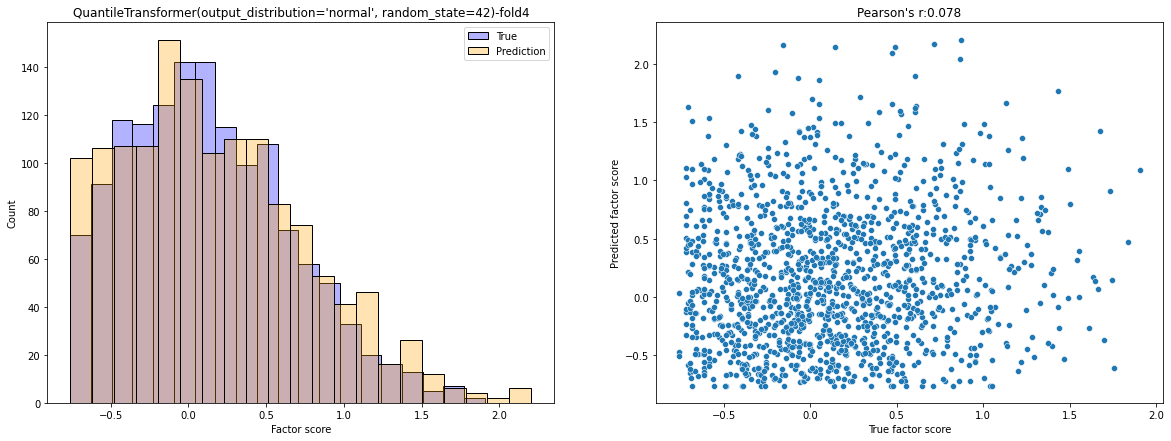

Fold5


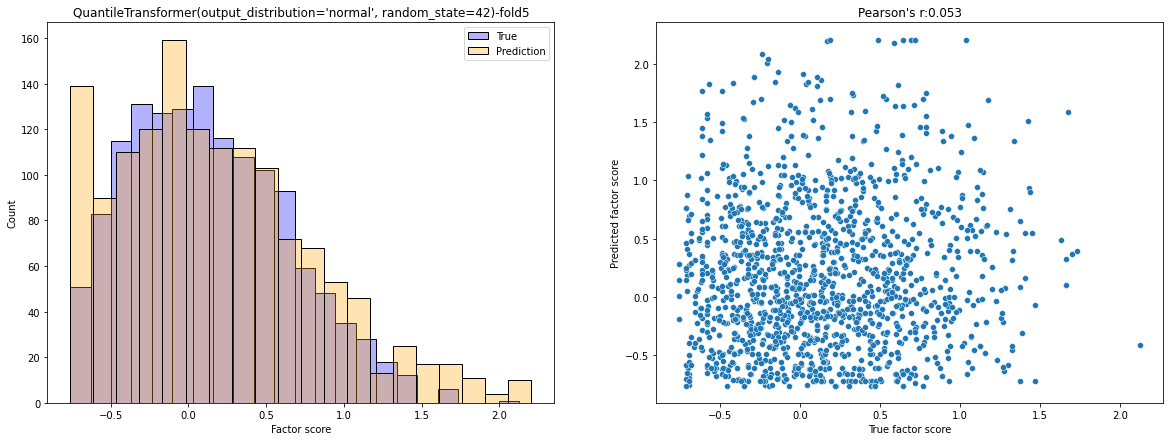

RobustScaler()
Fold1


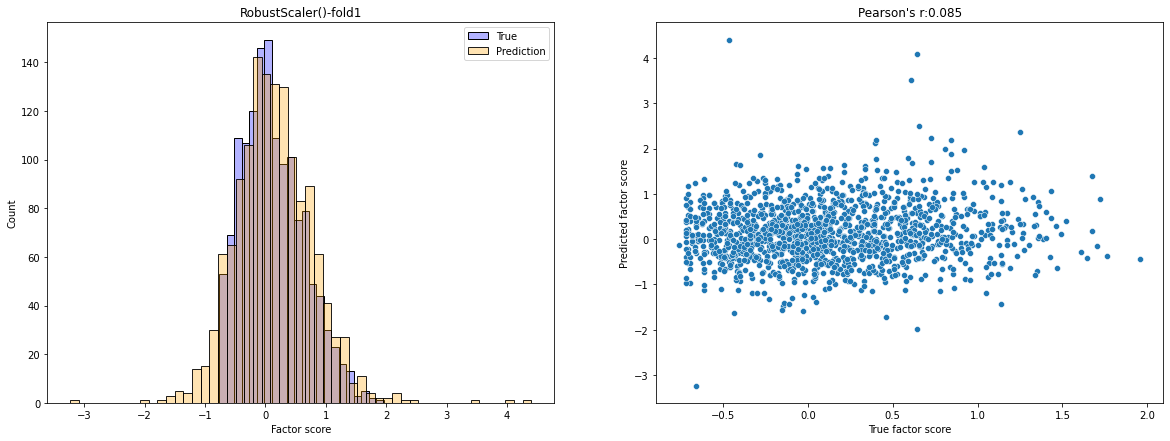

Fold2


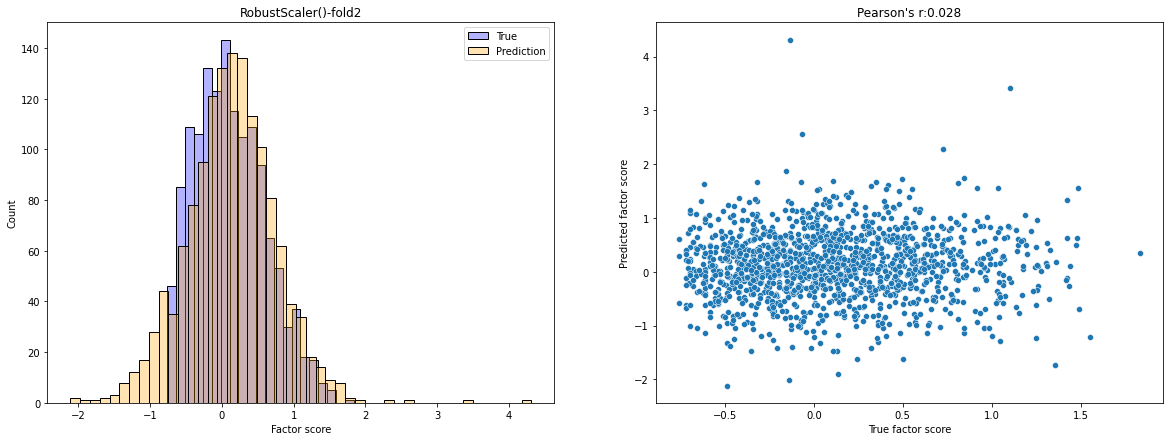

Fold3


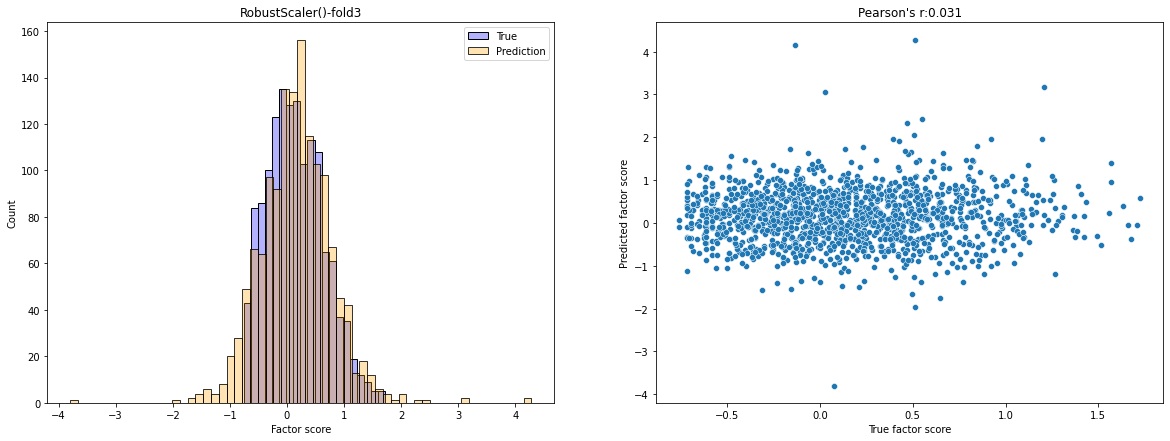

Fold4


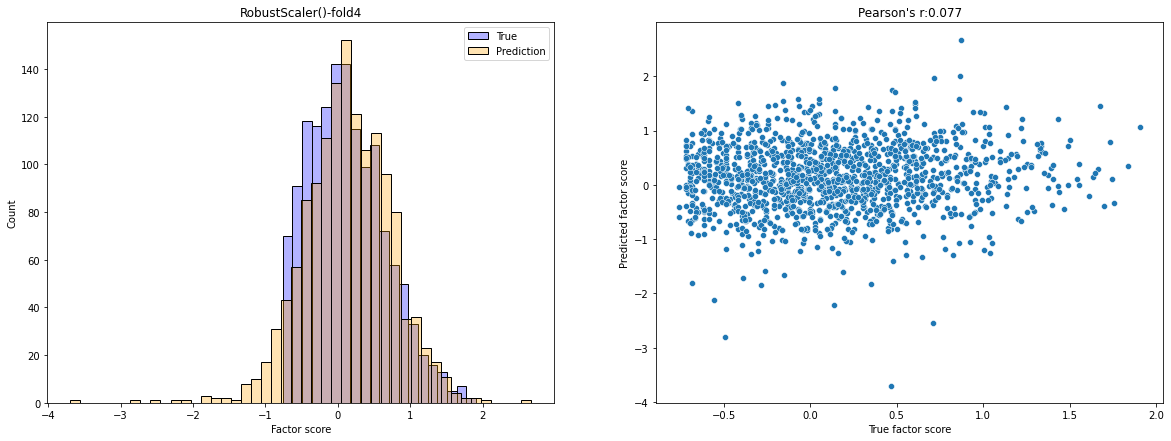

Fold5


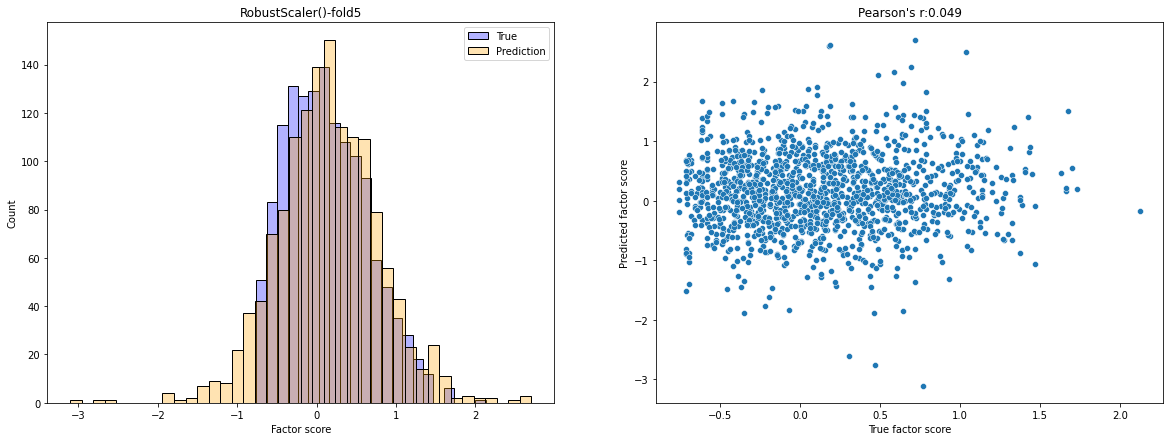

PowerTransformer()
Fold1


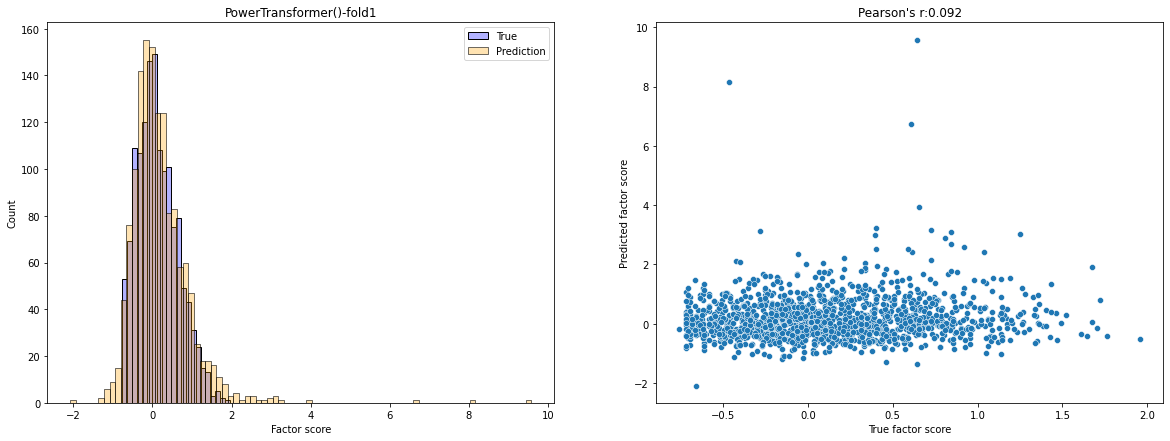

Fold2


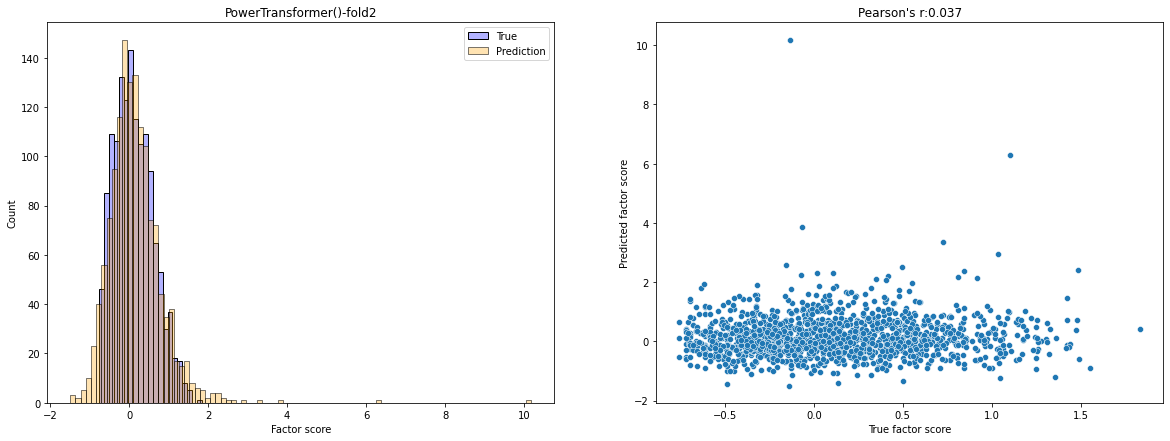

Fold3


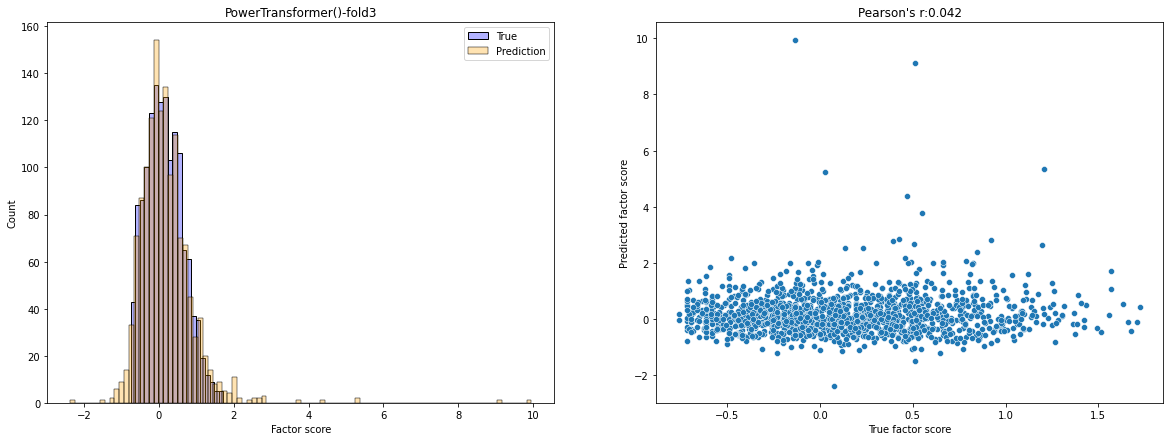

Fold4


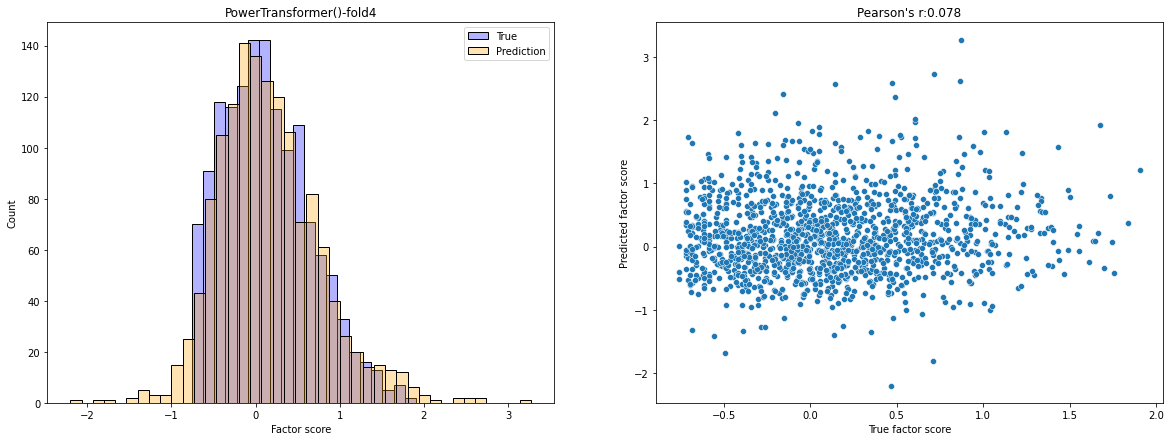

Fold5


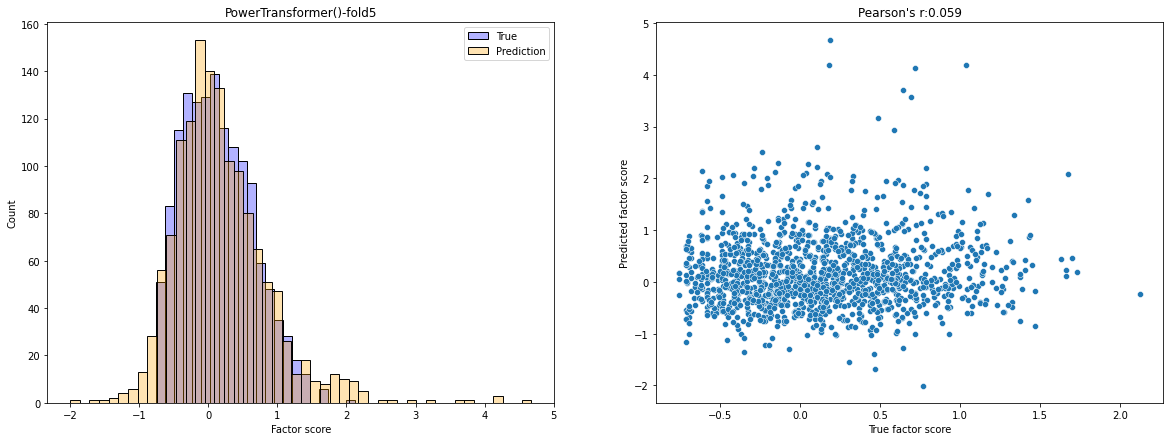

In [15]:
# cc_total_dict = {}
# for sc_ in sc_list:
#     print(str(sc_))
#     cc_total = []
#     for n_outer_cv in outer_cv_part:
#         print(f"Fold{n_outer_cv+1}")
# #         model = SVR()
#         model = KernelRidge(alpha=0.1)

#         outer_train_idx = outer_train_folds_idx[n_outer_cv]
#         outer_test_idx = outer_test_folds_idx[n_outer_cv]

#         X_train, y_train = X[outer_train_idx], y[outer_train_idx]
#         X_test, y_test = X[outer_test_idx], y[outer_test_idx]
        
# #         sc1 = sc_
# #         X_train = sc1.fit_transform(X_train)
# #         X_test = sc1.transform(X_test)
#         y_train = y_train.reshape(-1,1)
#         y_test = y_test.reshape(-1,1)
#         y_train = sc_.fit_transform(y_train)
#         y_test= sc_.transform(y_test)

#         X_train = stats.zscore(X_train, axis=1)
#         X_test = stats.zscore(X_test, axis=1)

#         model.fit(X_train, y_train)
#         model_pred = model.predict(X_test)
#         model_pred = sc_.inverse_transform(model_pred).reshape(-1,)
#         y_test = sc_.inverse_transform(y_test).reshape(-1,)
#         cc_fold = calc_pearsonr(model_pred,y_test)
#         cc_total.append(cc_fold)
        
#         fig = plt.figure(figsize=(20,7))
#         gs = GridSpec(nrows=1, ncols=2)
#         ax0 = fig.add_subplot(gs[0,0])
#         ax0.set_title(f"{sc_}-fold{n_outer_cv+1}")
#         sns.histplot(y_test,color='blue',alpha=0.3,label='True',ax =ax0)
#         sns.histplot(model_pred,color='orange',alpha=0.3,label='Prediction',ax =ax0)
#         plt.xlabel("Factor score")
#         plt.legend()

#         ax1 = fig.add_subplot(gs[0,1])
#         ax1.set_title("Pearson's r:%.3f" %cc_fold)
#         sns.scatterplot(x=y_test,y=model_pred,ax = ax1)
#         plt.xlabel('True factor score')
#         plt.ylabel('Predicted factor score')
#         plt.show()
        
#     cc_total_dict[str(sc_)] = cc_total
#     #     break

In [18]:
# result_df=pd.DataFrame(cc_total_dict)
# result_df_melt = result_df.melt()

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'StandardScaler()'),
  Text(1, 0, 'MinMaxScaler()'),
  Text(2, 0, 'QuantileTransformer(random_state=42)'),
  Text(3, 0, "QuantileTransformer(output_distribution='normal', random_state=42)"),
  Text(4, 0, 'RobustScaler()'),
  Text(5, 0, 'PowerTransformer()')])

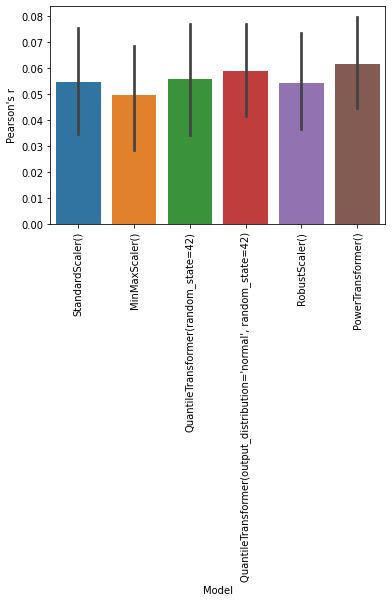

In [19]:
# sns.barplot(x='variable',y='value',data=result_df_melt)
# plt.xlabel("Model")
# plt.ylabel("Pearson's r")
# plt.xticks(rotation=90)

## Sampling 

In [139]:
result_df_mae = pd.DataFrame()
result_df_corr = pd.DataFrame()

In [140]:
sample_ratio_list = [0.03,0.04,0.05,0.06,0.07,0.08,
                    0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

In [141]:
#Sampling
for sample_ratio in sample_ratio_list:
    print("Sample ratio : ",sample_ratio)
    data_path = f"/users/hjd/IG_my_study/SNUH/data/sampled_ABCD/StratifiedSample_RSFC_{sample_ratio}.npz"
    data = np.load(data_path, allow_pickle=True)
    X = data["X"]

    targets_all = np.load(f"/users/hjd/IG_my_study/SNUH/data/sampled_ABCD/StratifiedSample_target_{sample_ratio}.npz",allow_pickle=True) 
    target_fs = targets_all[target_name]
    y = target_fs
    print(X.shape, y.shape)


    from sklearn.model_selection import KFold, ShuffleSplit

    outer_n_splits = n_cv

    outer_train_folds_idx = []
    outer_test_folds_idx = []

    outer_skf = ShuffleSplit(
        n_splits=outer_n_splits, test_size=0.20, random_state=seed)

    for n_outer, (outer_train_idx, outer_test_idx) in enumerate(
        outer_skf.split(X, y)):
        outer_train_folds_idx.append(outer_train_idx)
        outer_test_folds_idx.append(outer_test_idx)

        X_outer_train, y_outer_train = X[outer_train_idx], y[outer_train_idx]


    len(outer_train_folds_idx),len(outer_train_folds_idx[0]), len(outer_test_folds_idx[0])


    krr_cc_total = []
    krr_mae_total = []
    krr_p_total = []


    for n_outer_cv in outer_cv_part:
        print(n_outer_cv+1, end =' ')
        krr = KernelRidge(kernel='rbf')


        outer_train_idx = outer_train_folds_idx[n_outer_cv]
        outer_test_idx = outer_test_folds_idx[n_outer_cv]

        X_train, y_train = X[outer_train_idx], y[outer_train_idx]
        X_test, y_test = X[outer_test_idx], y[outer_test_idx]

        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)

        X_train = stats.zscore(X_train, axis=1)
        X_test = stats.zscore(X_test, axis=1)

        krr.fit(X_train, y_train)
        krr_pred = krr.predict(X_test)
        cc_fold,p_fold = stats.pearsonr(krr_pred.reshape(-1,),y_test.reshape(-1,))
        mae_fold = mean_absolute_error(krr_pred.reshape(-1,),y_test.reshape(-1,))
        krr_cc_total.append(cc_fold)
        krr_mae_total.append(mae_fold)
        krr_p_total.append(p_fold)


    result_df_mae[sample_ratio] = krr_mae_total
    result_df_corr[sample_ratio] = krr_cc_total

Sample ratio :  0.03
(206, 61776) (206,)
1 2 3 4 5 Sample ratio :  0.04
(276, 61776) (276,)
1 2 3 4 5 Sample ratio :  0.05
(344, 61776) (344,)
1 2 3 4 5 Sample ratio :  0.06
(414, 61776) (414,)
1 2 3 4 5 Sample ratio :  0.07
(482, 61776) (482,)
1 2 3 4 5 Sample ratio :  0.08
(552, 61776) (552,)
1 2 3 4 5 Sample ratio :  0.1
(690, 61776) (690,)
1 2 3 4 5 Sample ratio :  0.2
(1380, 61776) (1380,)
1 2 3 4 5 Sample ratio :  0.3
(2070, 61776) (2070,)
1 2 3 4 5 Sample ratio :  0.4
(2761, 61776) (2761,)
1 2 3 4 5 Sample ratio :  0.5
(3452, 61776) (3452,)
1 2 3 4 5 Sample ratio :  0.6
(4142, 61776) (4142,)
1 2 3 4 5 Sample ratio :  0.7
(4833, 61776) (4833,)
1 2 3 4 5 Sample ratio :  0.8
(5523, 61776) (5523,)
1 2 3 4 5 

In [145]:
sample_ratio = 1.0
result_df_mae[sample_ratio] = krr_mae_total
result_df_corr[sample_ratio] = krr_cc_total

In [146]:
result_df_mae['metric'] = 'MAE'
result_df_corr['metric'] = 'Corr'

result_df_fin = pd.concat([result_df_mae,result_df_corr])
result_df_fin

,0.03,0.04,0.05,0.06,0.07,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,metric
0,0.444670,0.451519,0.468443,0.448720,0.441392,0.463740,0.441350,0.441315,0.464243,0.445073,0.455582,0.454690,0.450441,0.459068,0.442866,MAE
1,0.412347,0.382934,0.423773,0.440875,0.430892,0.416754,0.490448,0.424196,0.453366,0.462619,0.446093,0.462657,0.453670,0.457096,0.440286,MAE
2,0.427416,0.395102,0.436759,0.470113,0.449625,0.472470,0.375964,0.424173,0.455041,0.449638,0.452550,0.433218,0.427553,0.444665,0.460466,MAE
3,0.474295,0.514502,0.443489,0.453799,0.389152,0.397263,0.417994,0.412664,0.446251,0.445505,0.458499,0.467002,0.446322,0.461471,0.444334,MAE
4,0.488000,0.512219,0.439674,0.441936,0.422586,0.451206,0.442979,0.465783,0.460359,0.465533,0.458613,0.444509,0.435614,0.449000,0.441359,MAE
0,-0.036744,0.055272,-0.081678,0.139536,0.016923,0.104503,-0.020845,0.133719,0.182396,0.134141,0.142042,0.144829,0.132496,0.112407,0.176751,Corr
1,0.404660,0.198747,0.137554,-0.070389,0.062537,0.284914,0.091660,0.199886,0.138301,0.086077,0.111674,0.136134,0.092321,0.156516,0.148829,Corr
2,0.196995,0.042544,0.228031,0.179244,0.233704,-0.045499,0.244949,0.135328,0.208448,0.107756,0.113916,0.189631,0.099675,0.156740,0.114704,Corr
3,0.093541,0.000916,0.107939,0.152336,0.118926,0.177638,0.117788,0.291079,0.203234,0.142848,0.081876,0.147746,0.134436,0.140253,0.155995,Corr
4,-0.215658,0.146729,0.040678,0.009453,0.186384,0.045112,0.170739,0.188716,0.180361,0.172840,0.165314,0.141277,0.225438,0.157895,0.151805,Corr


In [147]:
# result_df_fin.to_csv("/users/hjd/IG_my_study/SNUH/data/CFA_factors_results/pretrain_model_sampled/p/KRR_rbf_sampled_ABCD_result.csv",index=False)

## Fit ABCD ==> Predict SNUH

In [123]:
seed = 64
target_name = 'p'

In [124]:
# #Using whole RSFC
data_path = "/users/hjw/data/ABCD/npz_files/rsfc_p_site_scanner_si_ge.npz"
data = np.load(data_path, allow_pickle=True)
X = data["X"]

targets_all = np.load("/data4/SNU/data/ABCD_CFA_5factor.npz",allow_pickle=True) 
target_fs = targets_all[target_name]
y = target_fs
print(X.shape, y.shape)

# X = X[np.where(y>y.min())[0]]
# y = y[np.where(y>y.min())[0]]

print(X.shape, y.shape)

(6905, 61776) (6905,)
(6905, 61776) (6905,)


In [125]:
smoothing = True
gsr = False
censor = False

X2 = np.load(f"/data4/SNU/data/snuh_fc_temp_hjd/RSFC_Smoothing[{smoothing}]_GSR[{gsr}]_Censor[{censor}].npz")["X"]
y_df = pd.read_csv("/data4/SNU/data/demo_for_rsfc_df.csv", index_col=0)
cfa_fs = np.load("/data4/SNU/data/SNUH_CFA_5factor.npz")[target_name]
y_df["fs"] = cfa_fs

# # #Exclude outlier
# exclude_sbj = y_df.loc[(y_df['fs']>1.5)&(y_df['group']=='CON'),'new_id'].tolist()[0]
# exclude_sbj_idx = np.where(y_df['new_id'] == exclude_sbj)[0][0]
# y_df = y_df.loc[y_df['new_id']!=exclude_sbj,:]
# X = np.delete(X,exclude_sbj_idx,0)
     
y2 = y_df["fs"].values.reshape(-1, 1)
p_idx = 0
target_idx = p_idx
print(X2.max(),X2.min(),y2.max(),y2.min())
print(X2.shape, y2.shape)

3.826154 -1.5008454 2.0469999999999997 -0.862
(125, 61776) (125, 1)


In [126]:
krr = KernelRidge(kernel='rbf')

X_train = stats.zscore(X, axis=1)
X_test = stats.zscore(X2, axis=1)

krr.fit(X_train, y)
krr_pred = krr.predict(X_test)
cc_fold,p_fold = stats.pearsonr(krr_pred.reshape(-1,),y2.reshape(-1,))
mae_fold = mean_absolute_error(krr_pred.reshape(-1,),y2.reshape(-1,))

In [128]:
cc_fold, p_fold, mae_fold

(0.06229018558774197, 0.49013160971973535, 0.6493314214624784)

Text(0, 0.5, 'Predicted $p$-factor')

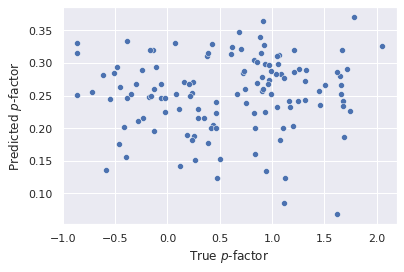

In [138]:
sns.set(style='darkgrid')
sns.scatterplot(y2.flatten(),krr_pred)
plt.xlabel("True $p$-factor")
plt.ylabel("Predicted $p$-factor")